# Using `mitiq` in VQE on $H_2$

<b>Abstract</b>: This notebook uses zero-noise extrapolation in `mitiq` to get a better estimate of the potential energy surface of molecular Hydrogen.

<img src="https://images.squarespace-cdn.com/content/v1/5879c888e4fcb54334f8d43f/1505431013539-Z43BYVJZ1W76R0OSS0LL/ke17ZwdGBToddI8pDm48kCVj22j6z99UmGAHyGo4-JdZw-zPPgdn4jUwVcJE1ZvWEtT5uBSRWt4vQZAgTJucoTqqXjS3CfNDSuuf31e0tVEblefBqtfxdDDrp0JJb4DWuF9MfQrDE_Iw9yivfvu2YBur-lC0WofN0YB1wFg-ZW0/hydrogen+molecule.png" alt="H2">

In [3]:
"""Imports."""
import matplotlib.pyplot as plt
import numpy as np
import sympy
from scipy.optimize import brute

import cirq
import mitiq
from mitiq.benchmarks.utils import noisy_simulation

# The Hamiltonian for $H_2$

We can write down the Hamiltonian for $H_2$ in the following form [1]

\begin{equation}
    H = g_0 I + g_1 Z_0 + g_2 Z_1 + g_3 Z_0 Z_1 + g_4 X_0 X_1 + g_5 Y_0 Y_1
\end{equation}

where $g_i$ are numerical values that depend on the bond length $R$ between Hydrogren molecules. This writing of the Hamiltonian:

1. Uses the minimal [STO-6G basis](https://en.wikipedia.org/wiki/STO-nG_basis_sets),
1. Uses the Bravyi-Kitaev transform, and
1. Reduces resources (qubit number) by symmetry considerations (see paper).

Each coefficient $g_i$ is a function of bond length $g_i = g_i(R)$. These values are specified in the table below in which the first column is the bond length $R$.

In [4]:
"""Define the Hamiltonian coefficents (shield your eyes).

The organization of the numeric values in the table below is

RADIUS  | g0    | g1    | g2    | g3    | g4    | g5

where it is understood each g is a function of the RADIUS R.

Source: Table 1 of Appendix C of [1].
"""

table = np.array([
        [0.2000, 2.8489, 0.5678, -1.4508, 0.6799, 0.07910, 0.07910],
        [0.2500, 2.1868, 0.5449, -1.2870, 0.6719, 0.07980, 0.07980],
        [0.3000, 1.7252, 0.5215, -1.1458, 0.6631, 0.08060, 0.08060],
        [0.3500, 1.3827, 0.4982, -1.0226, 0.6537, 0.08150, 0.08150],
        [0.4000, 1.1182, 0.4754, -0.9145, 0.6438, 0.08250, 0.08250],
        [0.4500, 0.9083, 0.4534, -0.8194, 0.6336, 0.08350, 0.08350],
        [0.5000, 0.7381, 0.4325, -0.7355, 0.6233, 0.08460, 0.08460],
        [0.5500, 0.5979, 0.4125, -0.6612, 0.6129, 0.08580, 0.08580],
        [0.6000, 0.4808, 0.3937, -0.5950, 0.6025, 0.08700, 0.08700],
        [0.6500, 0.3819, 0.3760, -0.5358, 0.5921, 0.08830, 0.08830],
        [0.7000, 0.2976, 0.3593, -0.4826, 0.5818, 0.08960, 0.08960],
        [0.7500, 0.2252, 0.3435, -0.4347, 0.5716, 0.09100, 0.09100],
        [0.8000, 0.1626, 0.3288, -0.3915, 0.5616, 0.09250, 0.09250],
        [0.8500, 0.1083, 0.3149, -0.3523, 0.5518, 0.09390, 0.09390],
        [0.9000, 0.06090, 0.3018, -0.3168, 0.5421, 0.09540, 0.09540],
        [0.9500, 0.01930, 0.2895, -0.2845, 0.5327, 0.09700, 0.09700],
        [1.000, -0.01720, 0.2779, -0.2550, 0.5235, 0.09860, 0.09860],
        [1.050, -0.04930, 0.2669, -0.2282, 0.5146, 0.1002, 0.1002],
        [1.100, -0.07780, 0.2565, -0.2036, 0.5059, 0.1018, 0.1018],
        [1.150, -0.1029, 0.2467, -0.1810, 0.4974, 0.1034, 0.1034],
        [1.200, -0.1253, 0.2374, -0.1603, 0.4892, 0.1050, 0.1050],
        [1.250, -0.1452, 0.2286, -0.1413, 0.4812, 0.1067, 0.1067],
        [1.300, -0.1629, 0.2203, -0.1238, 0.4735, 0.1083, 0.1083],
        [1.350, -0.1786, 0.2123, -0.1077, 0.4660, 0.1100, 0.1100],
        [1.400, -0.1927, 0.2048, -0.09290, 0.4588, 0.1116, 0.1116],
        [1.450, -0.2053, 0.1976, -0.07920, 0.4518, 0.1133, 0.1133],
        [1.500, -0.2165, 0.1908, -0.06660, 0.4451, 0.1149, 0.1149],
        [1.550, -0.2265, 0.1843, -0.05490, 0.4386, 0.1165, 0.1165],
        [1.600, -0.2355, 0.1782, -0.04420, 0.4323, 0.1181, 0.1181],
        [1.650, -0.2436, 0.1723, -0.03420, 0.4262, 0.1196, 0.1196],
        [1.700, -0.2508, 0.1667, -0.02510, 0.4204, 0.1211, 0.1211],
        [1.750, -0.2573, 0.1615, -0.01660, 0.4148, 0.1226, 0.1226],
        [1.800, -0.2632, 0.1565, -0.00880, 0.4094, 0.1241, 0.1241],
        [1.850, -0.2684, 0.1517, -0.00150, 0.4042, 0.1256, 0.1256],
        [1.900, -0.2731, 0.1472, 0.005200, 0.3992, 0.1270, 0.1270],
        [1.950, -0.2774, 0.1430, 0.01140, 0.3944, 0.1284, 0.1284],
        [2.000, -0.2812, 0.1390, 0.01710, 0.3898, 0.1297, 0.1297],
        [2.050, -0.2847, 0.1352, 0.02230, 0.3853, 0.1310, 0.1310],
        [2.100, -0.2879, 0.1316, 0.02720, 0.3811, 0.1323, 0.1323],
        [2.150, -0.2908, 0.1282, 0.03170, 0.3769, 0.1335, 0.1335],
        [2.200, -0.2934, 0.1251, 0.03590, 0.3730, 0.1347, 0.1347],
        [2.250, -0.2958, 0.1221, 0.03970, 0.3692, 0.1359, 0.1359],
        [2.300, -0.2980, 0.1193, 0.04320, 0.3655, 0.1370, 0.1370],
        [2.350, -0.3000, 0.1167, 0.04650, 0.3620, 0.1381, 0.1381],
        [2.400, -0.3018, 0.1142, 0.04950, 0.3586, 0.1392, 0.1392],
        [2.450, -0.3035, 0.1119, 0.05230, 0.3553, 0.1402, 0.1402],
        [2.500, -0.3051, 0.1098, 0.05490, 0.3521, 0.1412, 0.1412],
        [2.550, -0.3066, 0.1078, 0.05720, 0.3491, 0.1422, 0.1422],
        [2.600, -0.3079, 0.1059, 0.05940, 0.3461, 0.1432, 0.1432],
        [2.650, -0.3092, 0.1042, 0.06140, 0.3433, 0.1441, 0.1441],
        [2.700, -0.3104, 0.1026, 0.06320, 0.3406, 0.1450, 0.1450],
        [2.750, -0.3115, 0.1011, 0.06490, 0.3379, 0.1458, 0.1458],
        [2.800, -0.3125, 0.09970, 0.06650, 0.3354, 0.1467, 0.1467],
        [2.850, -0.3135, 0.09840, 0.06790, 0.3329, 0.1475, 0.1475]
])

In [5]:
"""Reduce the number of bond lengths considered."""
# only consider the first N bond lengths, and increase the spacing
N = 50
step = 2

# grab the reduced coeffs and bond lengths
table = table[0: N: step]
radii = table[:, 0]
coeffs = table[:, 1:]

# show the reduced set of coefficients at each bond length
print("Bond length (Angstroms): Coefficients (Hartree):")

for i in range(len(table)):
    print(radii[i],":\t\t\t",coeffs[i])

Bond length (Angstroms): Coefficients (Hartree):
0.2 :			 [ 2.8489  0.5678 -1.4508  0.6799  0.0791  0.0791]
0.3 :			 [ 1.7252  0.5215 -1.1458  0.6631  0.0806  0.0806]
0.4 :			 [ 1.1182  0.4754 -0.9145  0.6438  0.0825  0.0825]
0.5 :			 [ 0.7381  0.4325 -0.7355  0.6233  0.0846  0.0846]
0.6 :			 [ 0.4808  0.3937 -0.595   0.6025  0.087   0.087 ]
0.7 :			 [ 0.2976  0.3593 -0.4826  0.5818  0.0896  0.0896]
0.8 :			 [ 0.1626  0.3288 -0.3915  0.5616  0.0925  0.0925]
0.9 :			 [ 0.0609  0.3018 -0.3168  0.5421  0.0954  0.0954]
1.0 :			 [-0.0172  0.2779 -0.255   0.5235  0.0986  0.0986]
1.1 :			 [-0.0778  0.2565 -0.2036  0.5059  0.1018  0.1018]
1.2 :			 [-0.1253  0.2374 -0.1603  0.4892  0.105   0.105 ]
1.3 :			 [-0.1629  0.2203 -0.1238  0.4735  0.1083  0.1083]
1.4 :			 [-0.1927  0.2048 -0.0929  0.4588  0.1116  0.1116]
1.5 :			 [-0.2165  0.1908 -0.0666  0.4451  0.1149  0.1149]
1.6 :			 [-0.2355  0.1782 -0.0442  0.4323  0.1181  0.1181]
1.7 :			 [-0.2508  0.1667 -0.0251  0.4204  0.1211  0.1211]
1.8 :		

# Variational ansatz

We use the single-parameter variational ansatz shown in Fig. 1 of [1].

In [6]:
"""Defines the variational ansatz."""
# Variational parameter
theta = sympy.Symbol("theta")

# Qubits and circuit
qreg = cirq.LineQubit.range(2)
ansatz = cirq.Circuit(
    cirq.ops.ry(np.pi / 2).on(qreg[0]),
    cirq.ops.X.on(qreg[1]),
    cirq.ops.rx(-np.pi / 2).on(qreg[1]),
    cirq.ops.CNOT.on(*qreg),
    cirq.ops.rz(theta).on(qreg[1]),
    cirq.ops.CNOT.on(*qreg),
    cirq.ops.ry(-np.pi / 2).on(qreg[0]),
    cirq.ops.rx(np.pi / 2).on(qreg[1])
)
print("Ansatz circuit:")
print(ansatz)

Ansatz circuit:
0: ───Ry(0.5π)───────────────@───────────────@───Ry(-0.5π)───
                             │               │
1: ───X──────────Rx(-0.5π)───X───Rz(theta)───X───Rx(0.5π)────


# Computing expectations

In [7]:
"""Defines basis rotations to compute expectation values."""
# rotations = {
#     1: [cirq.ops.measure(qreg[0])],  # <Z_0>
#     2: [cirq.ops.measure(qreg[1])],  # <Z_1>
#     3: [cirq.ops.measure(qreg[0]), cirq.ops.measure(qreg[1])],  # <Z_0 Z_1>
#     4: [cirq.ops.ry(-np.pi / 1).on_each(*qreg), cirq.ops.measure_each(*qreg)],  # <X_0 X_1>
#     5: [cirq.ops.rx(np.pi / 1).on_each(*qreg), cirq.ops.measure_each(*qreg)]  # <Y_0 Y_1>
# }

npI = np.identity(2)
npX = np.array([[0., 1.], [1., 0.]])
npY = np.array([[0., -1j], [1j, 0.]])
npZ = np.array([[1., 0.], [0., -1.]])

observables = {
    1: np.kron(npZ, npI),
    2: np.kron(npI, npZ),
    3: np.kron(npZ, npZ),
    4: np.kron(npX, npX),
    5: np.kron(npY, npY)
}


def expectation(
    ansatz: cirq.Circuit,
    term_index: int,
    theta: float, 
    depo_noise_strength: float = 0.05,
) -> float:
    """Returns the expectation of a single term in the Hamiltonian.
    
    Args:
        ansatz: Circuit which defines the ansatz.
        term_index: Integer index of the term in the Hamiltonian.
        theta: Value of the variational parameter.
        depo_noise_strength: Depolarizing noise strength implemented after every moment.
    """
    if term_index not in {1, 2, 3, 4, 5}:
        raise ValueError("Valid term indices are 1 to 5.")

    return noisy_simulation(
        ansatz._resolve_parameters_({"theta": theta}),
        noise=depo_noise_strength,
        obs=observables[term_index]
    )


def term(
    ansatz: cirq.Circuit,
    radius_index: int, 
    term_index: int, 
    theta: float, 
    depo_noise_strength: float = 0.05
):
    """Computes one term of the energy <H>.
    
    Args:
        ansatz: Circuit which defines the ansatz.
        radius_index: Index of the radius (bond length).
        term_index: Index of the term in the Hamilton.
        theta: Value of the variational parameter.
        depo_noise_strength: Depolarizing noise strength implemented after every moment.
    """
    return coeffs[radius_index][term_index] * expectation(ansatz, term_index, theta, depo_noise_strength)


def energy(
    ansatz: cirq.Circuit,
    radius_index: int, 
    theta: float, 
    depo_noise_strength: float = 0.05
):
    """Computes the energy at a given bond length (radius).
    
    Args:
        ansatz: Circuit which defines the ansatz.
        radius_index: Index of the radius (bond length).
        theta: Value of the variational parameter.
        depo_noise_strength: Depolarizing noise strength implemented after every moment.
    """
    total = 0.0
    for term_index in range(1, 5 + 1):
        total += term(ansatz, radius_index, term_index, theta, depo_noise_strength)
    total += coeffs[radius_index][0]
    return total

# Energy landscape

Below we set a particular radius $r$ and sweep the $\theta$ parameter to visualize the energy landscape $E(\theta)$ using different strengths $p$ of depolarizing noise.

In [8]:
"""Sweep the parameter landscape."""
pvals = (0.00, 0.02, 0.04, 0.06)
thetas = np.linspace(0., 2. * np.pi, 20)

all_energies = []

for pval in pvals:
    energies = []
    for theta in thetas:
        energies.append(energy(ansatz, radius_index=0, theta=theta, depo_noise_strength=pval))
    all_energies.append(energies)

TypeError: _resolve_parameters_() missing 1 required positional argument: 'recursive'

In [12]:
from mitiq import about
about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.10.0dev

Core Dependencies
-----------------
Cirq Version:	0.10.0
NumPy Version:	1.20.3
SciPy Version:	1.4.1

Optional Dependencies
---------------------
PyQuil Version:	2.21.0
Qiskit Version:	None
Braket Version:	1.5.16

Python Version:	3.8.0
Platform Info:	Darwin (x86_64)


WARNING - No handles with labels found to put in legend.


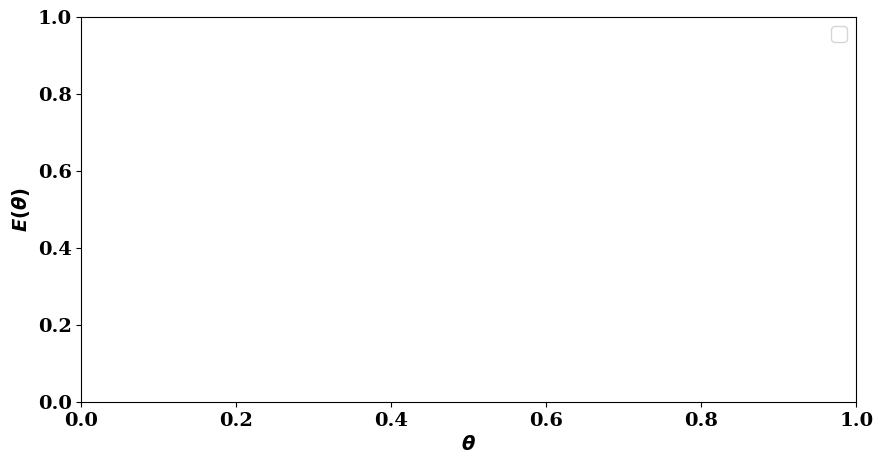

In [13]:
"""Plotting."""
plt.rcParams.update({"font.family": "serif", "font.size": 14, "font.weight": "bold"})
plt.figure(figsize=(10, 5))

for i, energies in enumerate(all_energies):
    plt.plot(
        thetas,
        energies, 
        "--s", 
        lw=3, 
        markersize=10,
        markeredgecolor="black",
        alpha=0.6, 
        label="$p = %0.2f$" %pvals[i]
    )


plt.xlabel(r"$\theta$");
plt.ylabel(r"$E(\theta)$");
plt.legend();
plt.show()
plt.close()

## Zero-noise extrapolation on $E(\theta)$

Here we use zero-noise extrapolation to mitigate the energy landscape.

In [17]:
"""Use ZNE to compute the energy landscape."""
from mitiq.zne.inference import LinearFactory
from mitiq.zne.inference import PolyFactory

lfac = LinearFactory(scale_factors=[1., 1.5, 2., 2.5, 3.])
pfac = mitiq.zne.inference.PolyFactory(order=2, scale_factors=[1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 5.5, 6.])

all_mitigated = []

for p in pvals[1:]:
    mitigated = []
    for theta in thetas:

        def executor(circuit: cirq.Circuit):
            return energy(circuit, radius_index=0, theta=theta, depo_noise_strength=p)

        zne = mitiq.zne.execute_with_zne(
            ansatz, executor, factory=pfac, scale_noise=mitiq.zne.scaling.fold_gates_at_random, num_to_average=1
        )
        mitigated.append(zne)
    all_mitigated.append(mitigated)

UnfoldableCircuitError: Circuit contains non-unitary channels which are not terminal measurements and cannot be folded.

In [18]:
"""Plotting."""
plt.rcParams.update({"font.family": "serif", "font.size": 14, "font.weight": "bold"})
plt.figure(figsize=(15, 5))

colors = ["blue", "orange", "green", "red", "purple", "brown"]

plt.subplot(121)
plt.title("Unmitigated")
for i in range(len(all_energies)):
    plt.plot(
        thetas,
        all_energies[i], 
        "--s", 
        lw=3, 
        markersize=10,
        markeredgecolor="black",
        alpha=0.6, 
        color=colors[i],
        label="$p = %0.2f$" % pvals[i]
    )
plt.xlabel(r"$\theta$");
plt.ylabel(r"$E(\theta)$");
plt.legend();

plt.subplot(122)
plt.title("Mitigated")
plt.plot(
        thetas,
        all_energies[0], 
        "--s", 
        lw=3, 
        markersize=10,
        markeredgecolor="black",
        alpha=0.6, 
        color=colors[0]
    )
for i in range(len(all_mitigated)):
    plt.plot(
        thetas,
        all_mitigated[i], 
        "--o", 
        lw=3, 
        markersize=10,
        markeredgecolor="black",
        alpha=0.6,
        color=colors[i + 1]
    )


plt.xlabel(r"$\theta$");
plt.tight_layout();
plt.show()
plt.close()

WARNING - No handles with labels found to put in legend.


IndexError: list index out of range

In [22]:
"""Use ZNE to compute the energy landscape."""

lfac = LinearFactory(scale_factors=[1., 1.5, 2., 2.5, 3.])
pfac = PolyFactory(order=2, scale_factors=[1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 5.5, 6.])

all_mitigated = []

for p in pvals[1:]:
    mitigated = []
    for theta in thetas:

        def executor(circuit: cirq.Circuit):
            return energy(circuit, radius_index=0, theta=theta, depo_noise_strength=p)

        zne = mitiq.zne.execute_with_zne(
            ansatz, executor, factory=pfac, scale_noise=mitiq.zne.scaling.fold_gates_at_random, num_to_average=5
        )
        mitigated.append(zne)
    all_mitigated.append(mitigated)

UnfoldableCircuitError: Circuit contains non-unitary channels which are not terminal measurements and cannot be folded.

In [23]:
"""Plotting."""
plt.rcParams.update({"font.family": "serif", "font.size": 14, "font.weight": "bold"})
plt.figure(figsize=(15, 5))

colors = ["blue", "orange", "green", "red", "purple", "brown"]

plt.subplot(121)
plt.title("Unmitigated")
for i in range(len(all_energies)):
    plt.plot(
        thetas,
        all_energies[i], 
        "--s", 
        lw=3, 
        markersize=10,
        markeredgecolor="black",
        alpha=0.6, 
        color=colors[i],
        label="$p = %0.2f$" % pvals[i]
    )
plt.xlabel(r"$\theta$");
plt.ylabel(r"$E(\theta)$");
plt.legend();

plt.subplot(122)
plt.title("Mitigated")
plt.plot(
        thetas,
        all_energies[0], 
        "--s", 
        lw=3, 
        markersize=10,
        markeredgecolor="black",
        alpha=0.6, 
        color=colors[0]
    )
for i in range(len(all_mitigated)):
    plt.plot(
        thetas,
        all_mitigated[i], 
        "--o", 
        lw=3, 
        markersize=10,
        markeredgecolor="black",
        alpha=0.6,
        color=colors[i + 1]
    )


plt.xlabel(r"$\theta$");
plt.tight_layout();
plt.show()
plt.close()

WARNING - No handles with labels found to put in legend.


IndexError: list index out of range

# Potential energy surface

Now we vary the radius $r$ and compute the minimum energy $\min_\theta E(\theta, r)$ at each value of $r$. This produces the potential energy surface $E^{\text{opt}}(r)$.

In [24]:
"""Optimize the energy at each radius."""
# Channel strengths to consider
pvals = (0.00, 0.02, 0.04, 0.06) #, 0.08, 0.10)

# Lists to store output
best_thetas = []
best_energies = []

# Do the minimization at each channel strength at each radius
for pval in pvals:
    print(f"\nStatus: p = {pval}")
    these_thetas = []
    these_energies = []
    for i in range(len(radii)):
        print(f"\tStatus: radius = {radii[i]}", end="\r")
        
        def obj(theta):
            return energy(ansatz, radius_index=i, theta=theta, depo_noise_strength=pval)
        
        res = brute(obj, ranges=[(0, 2 * np.pi)], Ns=10, finish=None, full_output=True)
        these_thetas.append(res[0])
        these_energies.append(res[1])
        
    best_thetas.append(these_thetas)
    best_energies.append(these_energies)


Status: p = 0.0


TypeError: _resolve_parameters_() missing 1 required positional argument: 'recursive'

WARNING - No handles with labels found to put in legend.


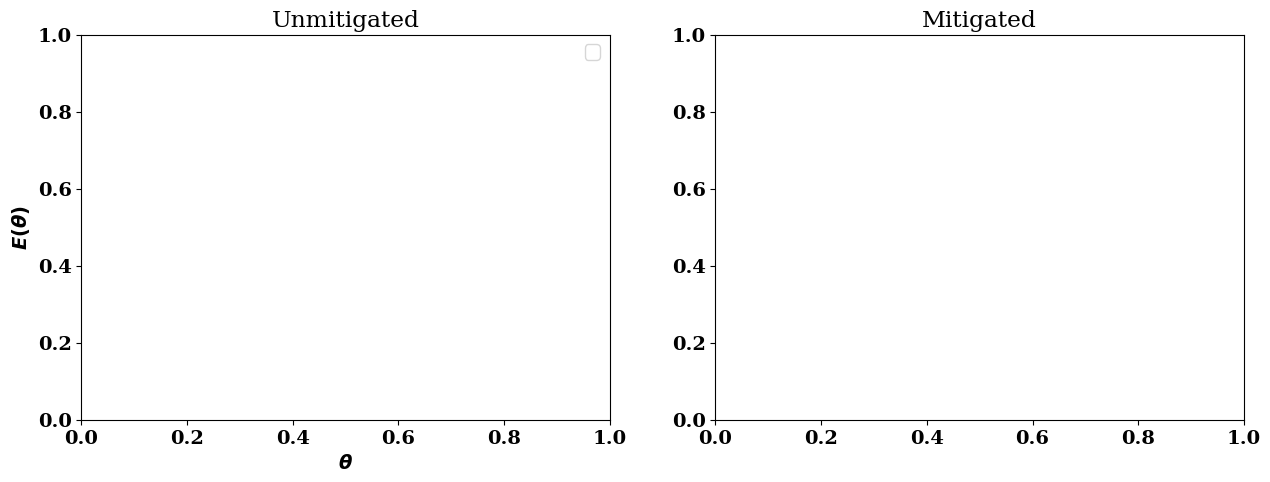

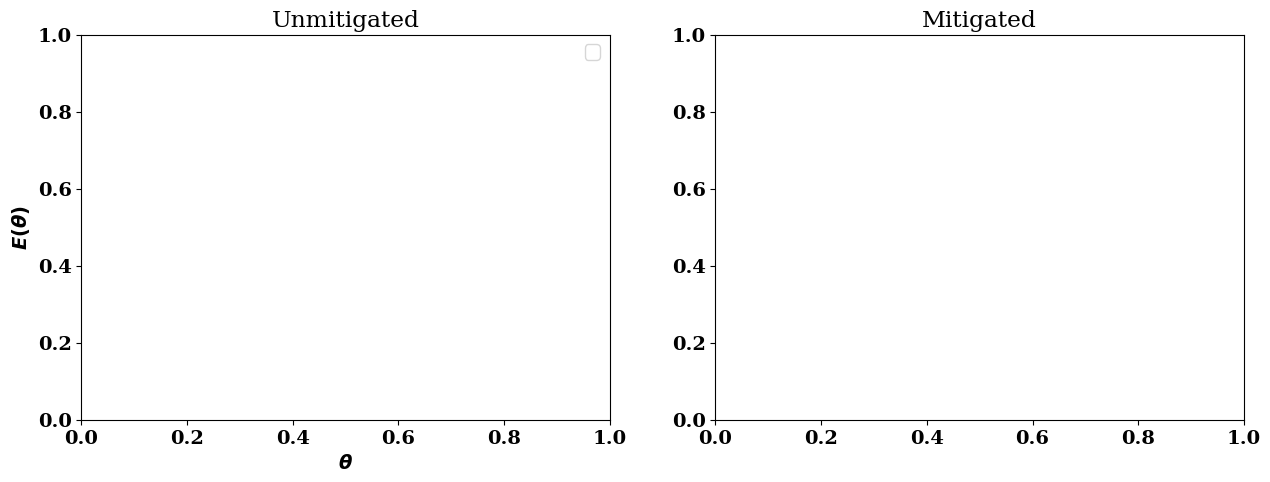

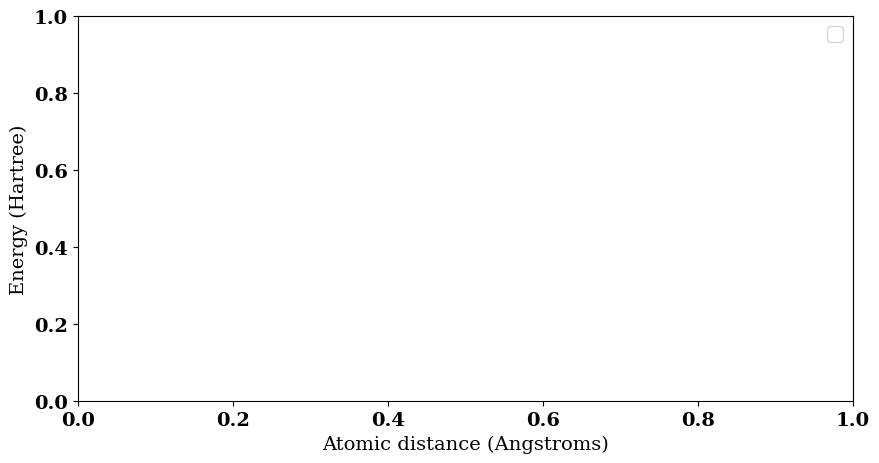

In [25]:
"""Plotting."""
plt.rcParams.update({"font.family": "serif", "font.size": 14, "font.weight": "bold"})
plt.figure(figsize=(10, 5))

colors = ["blue", "orange", "green", "red", "purple", "brown"]

for pval, opt_energies in zip(pvals, best_energies):
    plt.plot(
        radii, 
        opt_energies, 
        "--s", 
        lw=2, 
        markersize=10,
        markeredgecolor="black",
        alpha=0.7,
        label=f"$p = {pval}$"
    )

plt.xlabel("Atomic distance (Angstroms)");
plt.ylabel("Energy (Hartree)");
plt.legend();
plt.show()
plt.close()

## Zero-noise extrapolation

In [26]:
"""Optimize the energy at each radius using zero-noise extrapolation."""
# Factory to use in mitigation
lfac = LinearFactory(scale_factors=[1., 1.5, 2., 2.5, 3.])
pfac = PolyFactory(
    order=3,
    scale_factors=[1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 5.5, 6.]
)

# Lists to store output
best_mitigated_thetas = []
best_mitigated_energies = []

# Do the minimization at each channel strength at each radius
for pval in pvals[1:]:
    print(f"\nStatus: p = {pval}")
    these_thetas = []
    these_energies = []
    for i in range(len(radii)):
        print(f"\tStatus: radius = {radii[i]}", end="\r")
        
        def obj(theta):
            def executor(circuit: cirq.Circuit):
                return energy(circuit, radius_index=i, theta=theta, depo_noise_strength=pval)
            return mitiq.execute_with_zne(ansatz, executor, factory=pfac, num_to_average=5)
        
        res = brute(obj, ranges=[(0, 2 * np.pi)], Ns=10, finish=None, full_output=True)
        these_thetas.append(res[0])
        these_energies.append(res[1])
        
    best_mitigated_thetas.append(these_thetas)
    best_mitigated_energies.append(these_energies)


Status: p = 0.02


AttributeError: module 'mitiq' has no attribute 'execute_with_zne'

NameError: name 'best_energies' is not defined

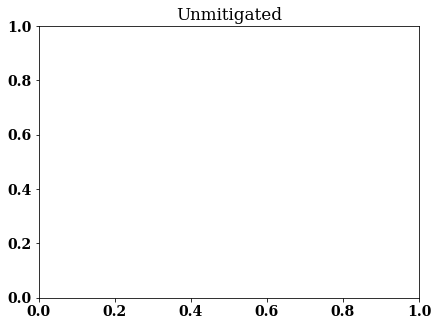

In [9]:
"""Plotting."""
plt.rcParams.update({"font.family": "serif", "font.size": 14, "font.weight": "bold"})
plt.figure(figsize=(15, 5))

colors = ["blue", "orange", "green", "red", "purple", "brown"]

plt.subplot(121)
plt.title("Unmitigated")
for pval, opt_energies in zip(pvals, best_energies):
    plt.plot(
        radii, 
        opt_energies, 
        "--s", 
        lw=2, 
        markersize=10,
        markeredgecolor="black",
        alpha=0.7,
        label=f"$p = {pval}$"
    )
plt.ylim(
    min([np.min(best_energies), np.min(best_mitigated_energies)]) - 0.1, 
    max([np.max(best_energies), np.max(best_mitigated_energies)]) + 0.1
)
plt.xlabel("Atomic distance (Angstroms)");
plt.ylabel("Energy (Hartree)");
plt.legend();


plt.subplot(122)
plt.title("Mitigated")
plt.plot(
        radii, 
        best_energies[0], 
        "-s", 
        lw=2, 
        markersize=10,
        markeredgecolor="black",
        alpha=0.7,
        label=f"$p = 0.0$",
        zorder=1
    )
i = 0
for pval, opt_energies in zip(pvals[1:], best_mitigated_energies):
    i += 1
    plt.plot(
        radii,
        opt_energies,
        "-o",
        lw=2,
        markersize=10,
        markeredgecolor="black",
        alpha=0.7,
        label=f"$p = {pval}$",
        zorder=0
    )
plt.ylim(
    min([np.min(best_energies), np.min(best_mitigated_energies)]) - 0.1, 
    max([np.max(best_energies), np.max(best_mitigated_energies)]) + 0.1
)
    
plt.xlabel("Atomic distance (Angstroms)");
plt.legend();

# plt.savefig("h2-surface.pdf", format="pdf")

In [27]:
"""Quantify the difference between the curves."""
diffs = np.zeros(len(pvals[1:]))
diffs_unmitigated = np.zeros(len(pvals[1:]))
for i in range(len(pvals[1:])):
    diffs[i] = np.linalg.norm((np.array(best_energies[0]) - np.array(best_mitigated_energies[i])), ord=2)
    diffs_unmitigated[i] = np.linalg.norm((np.array(best_energies[0]) - np.array(best_energies[i + 1])), ord=2)

diffs /= np.linalg.norm(np.array(best_energies[0]), ord=2)
diffs_unmitigated /= np.linalg.norm(np.array(best_energies[0]), ord=2)

IndexError: list index out of range

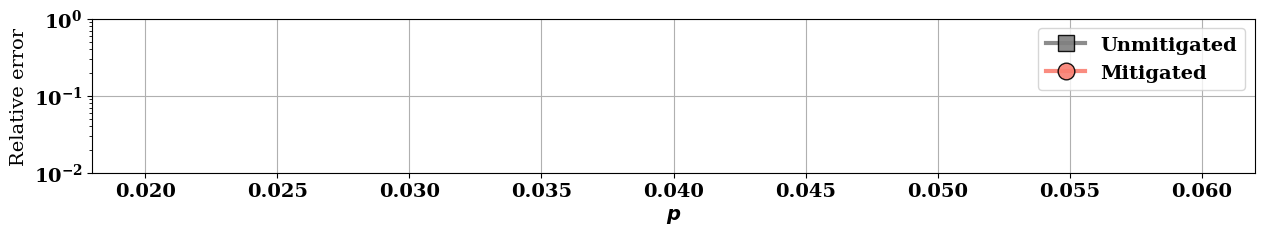

In [28]:
plt.rcParams.update({"font.family": "serif", "font.size": 14, "font.weight": "bold"})
plt.figure(figsize=(15, 2))


plt.semilogy(
    pvals[1:], 
    diffs_unmitigated,
    "-s",
    color="gray",
    lw=3,
    markersize=12,
    markeredgecolor="black",
    alpha=0.9,
    label="Unmitigated"
)

plt.semilogy(
    pvals[1:], 
    diffs,
    "-o",
    color="salmon",
    lw=3,
    markersize=12,
    markeredgecolor="black",
    alpha=0.9,
    label="Mitigated"
)



plt.ylabel("Relative error");
plt.xlabel("$p$");
plt.ylim(1e-2, 1);
plt.grid();
plt.legend();
plt.show()
plt.close()
# plt.savefig("h2-surface-error-v2.pdf", format="pdf")

In [29]:
"""Different metric."""
diffs = np.zeros(len(pvals[1:]))
for i in range(len(pvals[1:])):
    diffs[i] = np.linalg.norm(
        (np.array(best_energies[0]) - best_energies[i + 1]) / (np.array(best_energies[0]) - np.array(best_mitigated_energies[i])),
        ord=2
    )

IndexError: list index out of range

/opt/miniconda3/envs/mitiqdev/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


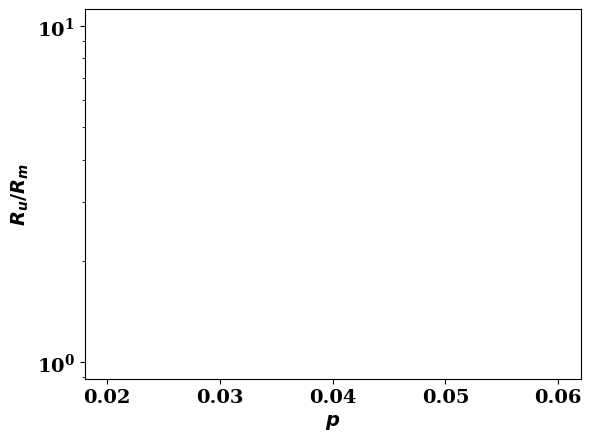

In [30]:
plt.semilogy(pvals[1:], diffs, "--o")
plt.ylabel("$R_u / R_m$");
plt.xlabel("$p$");
plt.show()
plt.close()

# References

[1] P. J. J. O’Malley et al., “[Scalable Quantum Simulation of Molecular Energies](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031007),” 
Physical Review X, vol. <b>6</b>, no. 3, Jul. 2016.
